# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1193]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, countDistinct, \
    min, max, avg, split, round, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType, BooleanType
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [1111]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

### Common Functions

In [1112]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [583]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

data.printSchema()
data.take(3)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57), city='Bakersfield', state=' CA'),
 Row(artist='Five Iron Frenzy', auth='Logged In', gender='M', itemInSession=79, length=236.09424, level='free', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', regDate=datetime.datetime(2018, 9, 30, 20, 20, 30), tsDate=datetime.datetime(2018, 10, 1, 2, 3), city='Boston-Cambridge-Newton', state=' MA-NH'),
 Row(artist='Adam Lambert', auth='Logged In', gender

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### EDA on churned users

In [584]:
cols = ['tsDate', 'auth', 'level', 'page', 'status', 'song', 'artist', 'length', 'Churn']

In [640]:
# Count churned users using Cancellation Confirmation evet
data.where(data.page == 'Cancellation Confirmation').dropDuplicates().count()

52

In [797]:
# Label churned users

# extract churned users
churned = data.where(data.page.isin(['Cancellation Confirmation'])) \
    .dropDuplicates() \
    .select('userId') \
    .collect()

# add new column using churned list
churned_uids = [x.userId for x in churned];
is_churn = udf(lambda x: 1 if x in churned_uids else 0, IntegerType())
data = data.withColumn('churn', is_churn('userId'))
data.take(3)

# check
data.where(data.churn == True).select('userId').dropDuplicates().count()

52

In [1114]:
n_churned = len(churned)
n_active = data.select('userId').dropDuplicates().count() - n_churned
print(n_churned)
print(n_active)

52
173


Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Churn vs page activity

In [1347]:
# Prepare dataset
def get_df(page):
    return data.where(data.page == page) \
        .groupby('userId', 'churn', 'sessionId') \
        .agg(count('sessionId').alias('logCount')) \
        .groupby('userId', 'churn') \
        .agg(avg('logCount').alias(page)) \
        .toPandas()

In [1384]:
def get_churn_mean(page):
    return data.where(data.page == page) \
        .groupby('userId', 'churn', 'sessionId') \
        .agg(count('sessionId').alias('logCount')) \
        .groupby('userId', 'churn') \
        .agg(avg('logCount').alias(page)) \
        .groupby('churn') \
        .agg(avg(page))

In [1385]:
get_churn_mean('NextSong').show()

+-----+------------------+
|churn|     avg(NextSong)|
+-----+------------------+
|    1|63.537152578095224|
|    0| 72.96967249911357|
+-----+------------------+



In [1386]:
get_churn_mean('Thumbs Up').show()

+-----+------------------+
|churn|    avg(Thumbs Up)|
+-----+------------------+
|    1| 4.279693814443338|
|    0|4.9075917705904715|
+-----+------------------+



In [1387]:
get_churn_mean('Thumbs Down').show()

+-----+------------------+
|churn|  avg(Thumbs Down)|
+-----+------------------+
|    1| 1.838778453300512|
|    0|1.8282693906593053|
+-----+------------------+



In [1388]:
get_churn_mean('Add to Playlist').show()

+-----+--------------------+
|churn|avg(Add to Playlist)|
+-----+--------------------+
|    1|   2.942379760336282|
|    0|   3.195701432845371|
+-----+--------------------+



In [1389]:
get_churn_mean('Add Friend').show()

+-----+------------------+
|churn|   avg(Add Friend)|
+-----+------------------+
|    1|  2.63313529904439|
|    0|3.0522598254937874|
+-----+------------------+



In [1390]:
get_churn_mean('Roll Advert').show()

+-----+-----------------+
|churn| avg(Roll Advert)|
+-----+-----------------+
|    1|3.730709532297768|
|    0|3.097638542563953|
+-----+-----------------+



In [1400]:
get_churn_mean('Error').show()

+-----+------------------+
|churn|        avg(Error)|
+-----+------------------+
|    1|1.0681818181818181|
|    0|1.1289473684210525|
+-----+------------------+



In [1392]:
def get_churn_total_mean(page):
    return data.where(data.page == page) \
        .groupby('churn', 'userId') \
        .agg(count('churn').alias('logCount')) \
        .groupby('churn') \
        .agg(avg('logCount').alias(page))

In [1393]:
get_churn_total_mean('NextSong').show()

+-----+------------------+
|churn|          NextSong|
+-----+------------------+
|    1| 699.8846153846154|
|    0|1108.1734104046243|
+-----+------------------+



In [1394]:
get_churn_total_mean('Thumbs Up').show()

+-----+-----------------+
|churn|        Thumbs Up|
+-----+-----------------+
|    1|            37.18|
|    0|62.89411764705882|
+-----+-----------------+



In [1395]:
get_churn_total_mean('Thumbs Down').show()

+-----+------------------+
|churn|       Thumbs Down|
+-----+------------------+
|    1|10.333333333333334|
|    0|13.225806451612904|
+-----+------------------+



In [1396]:
get_churn_total_mean('Add to Playlist').show()

+-----+-----------------+
|churn|  Add to Playlist|
+-----+-----------------+
|    1|            20.76|
|    0|33.26060606060606|
+-----+-----------------+



In [1397]:
get_churn_total_mean('Add Friend').show()

+-----+------------------+
|churn|        Add Friend|
+-----+------------------+
|    1|14.454545454545455|
|    0| 22.47530864197531|
+-----+------------------+



In [1398]:
get_churn_total_mean('Roll Advert').show()

+-----+-----------------+
|churn|      Roll Advert|
+-----+-----------------+
|    1|            19.34|
|    0|18.89171974522293|
+-----+-----------------+



In [1399]:
get_churn_total_mean('Error').show()

+-----+------------------+
|churn|             Error|
+-----+------------------+
|    1|1.4545454545454546|
|    0|2.3157894736842106|
+-----+------------------+



In [1377]:
def plot_churn(page, kde=False):
    df = get_df(page)
    plt.figure(figsize=(12, 4))
    df_active = df[df.churn == 0][page]
    df_churned = df[df.churn == 1][page]
    plt.figure(figsize=(15,6));
    sb.distplot(df_active, bins=20, label='active', kde=kde);
    sb.distplot(df_churned, bins=20, label = 'churned', kde=kde);
    plt.xlabel('Average ' + page)
    ax = plt.gca()
    ax.set_title('Churn vs. Average ' + page);
    plt.legend(loc='upper right');
    plt.show()

<Figure size 864x288 with 0 Axes>

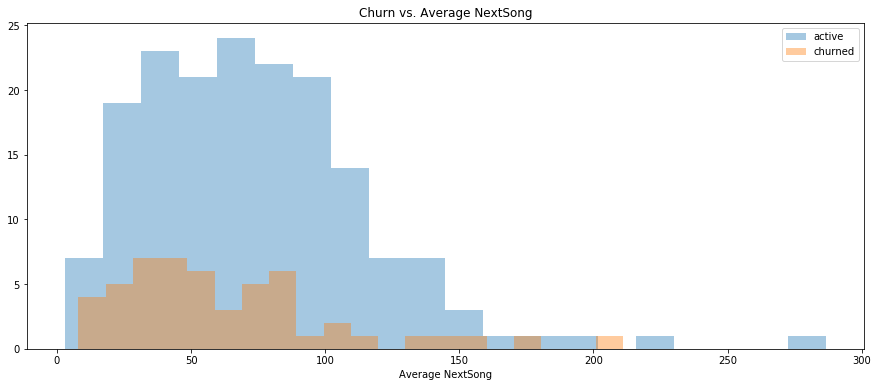

In [1378]:
plot_churn('NextSong')

<Figure size 864x288 with 0 Axes>

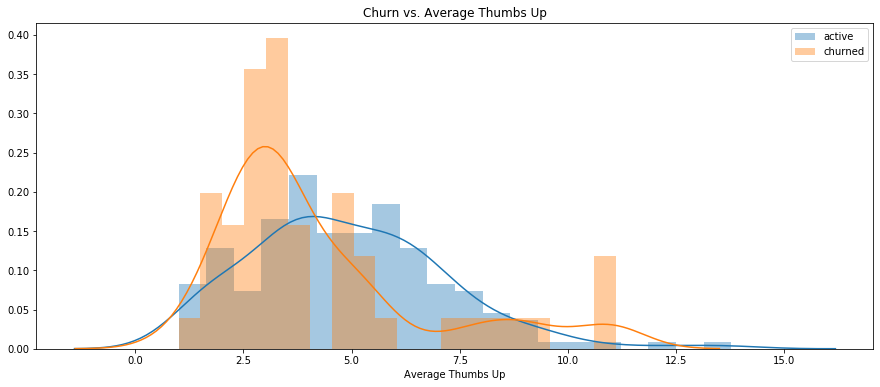

In [1361]:
plot_churn('Thumbs Up')

<Figure size 864x288 with 0 Axes>

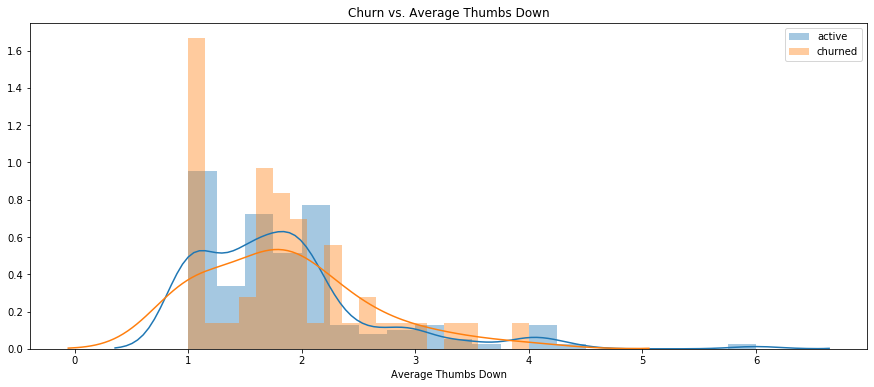

In [1362]:
plot_churn('Thumbs Down')

<Figure size 864x288 with 0 Axes>

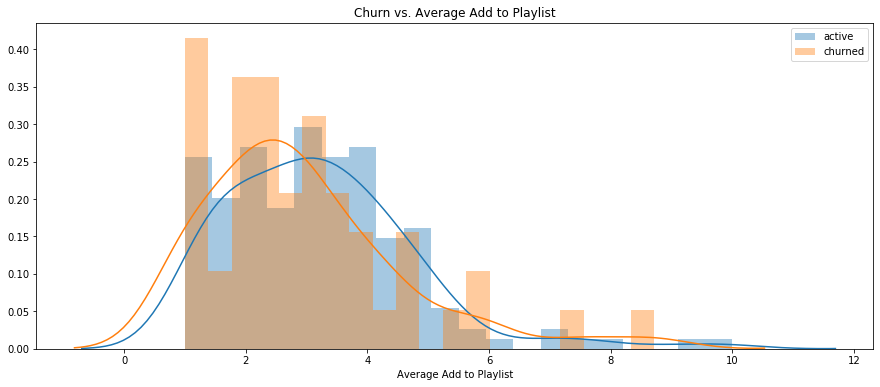

In [1365]:
plot_churn('Add to Playlist')

<Figure size 864x288 with 0 Axes>

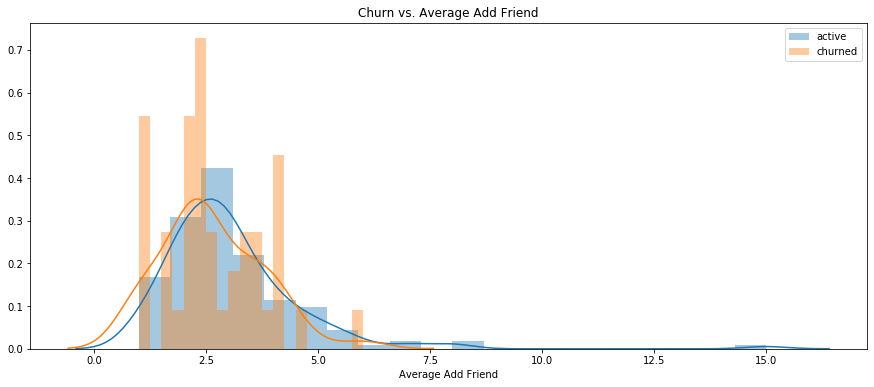

In [1366]:
plot_churn('Add Friend')

<Figure size 864x288 with 0 Axes>

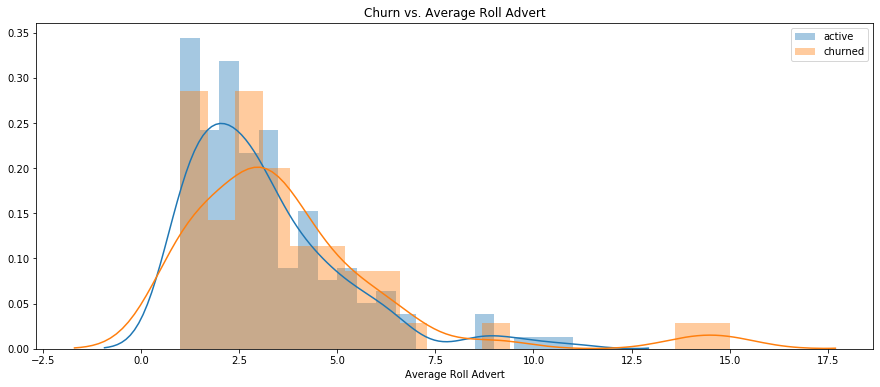

In [1368]:
plot_churn('Roll Advert')

<Figure size 864x288 with 0 Axes>

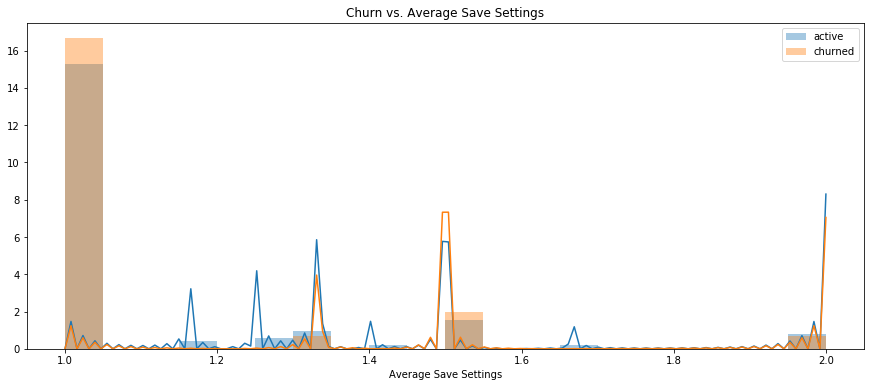

In [1370]:
plot_churn('Save Settings')

In [1372]:
df = get_df('Save Settings')

<Figure size 864x288 with 0 Axes>

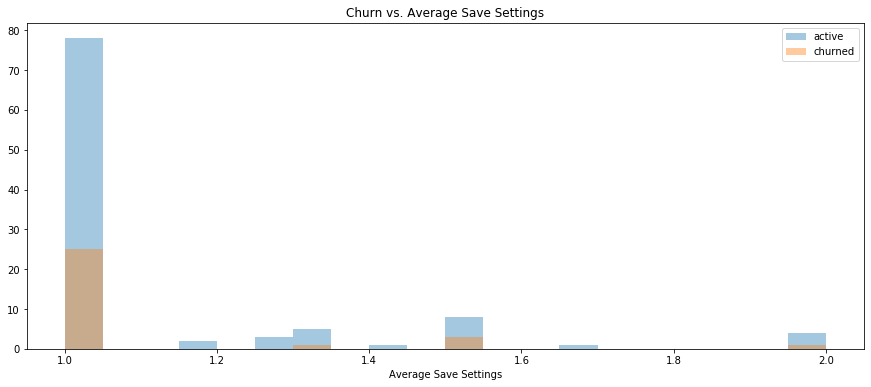

In [1376]:
    page = 'Save Settings'
    kde=False
    plt.figure(figsize=(12, 4))
    df_active = df[df.churn == 0][page]
    df_churned = df[df.churn == 1][page]
    plt.figure(figsize=(15,6));
    sb.distplot(df_active, bins=20, label='active', kde=kde);
    sb.distplot(df_churned, bins=20, label = 'churned', kde=kde);
    plt.xlabel('Average ' + page)
    ax = plt.gca()
    ax.set_title('Churn vs. Average ' + page);
    plt.legend(loc='upper right');
    plt.show()

### Examine Session

In [1142]:
cols = ['sessionId', 'itemInSession', 'userId', 'tsDate', 'page']

In [1143]:
data.select(cols).sort('itemInSession').show(10)

+---------+-------------+------+-------------------+--------+
|sessionId|itemInSession|userId|             tsDate|    page|
+---------+-------------+------+-------------------+--------+
|      149|            0|300009|2018-10-17 11:20:34|NextSong|
|      183|            0|300021|2018-10-18 18:50:46|    Help|
|      173|            0|300023|2018-10-17 16:12:25|NextSong|
|      160|            0|300025|2018-10-17 07:41:52|NextSong|
|      178|            0|300021|2018-10-17 17:24:57|    Home|
|      138|            0|300001|2018-10-18 01:45:39|    Home|
|      179|            0|300009|2018-10-18 17:51:27|NextSong|
|      120|            0|300019|2018-10-18 07:24:43|    Home|
|      166|            0|300011|2018-10-16 20:07:35|    Home|
|       91|            0|300014|2018-10-18 10:46:39|    Home|
+---------+-------------+------+-------------------+--------+
only showing top 10 rows



In [1174]:
# Aggregate a given user by session extracting session's startDate, endDate, end log count
data.where(data.userId == 10) \
    .groupby('userId', 'sessionId') \
    .agg(min('tsDate').alias('startDate'), max('tsDate').alias('endDate'), count('sessionId').alias('logCount')) \
    .sort('sessionId') \
    .show()

+------+---------+-------------------+-------------------+--------+
|userId|sessionId|          startDate|            endDate|logCount|
+------+---------+-------------------+-------------------+--------+
|    10|        9|2018-10-08 04:20:20|2018-10-08 08:16:12|      70|
|    10|      595|2018-10-18 05:38:43|2018-10-19 07:26:38|     449|
|    10|     1047|2018-10-29 23:02:26|2018-10-30 00:33:51|      25|
|    10|     1414|2018-11-03 15:27:42|2018-11-03 19:43:18|      78|
|    10|     1592|2018-11-15 20:34:26|2018-11-16 01:26:29|      78|
|    10|     1981|2018-11-19 08:14:10|2018-11-19 13:49:48|      95|
+------+---------+-------------------+-------------------+--------+



In [1176]:
# Churn vs average number of logs per session
data.groupby('userId', 'sessionId') \
    .count() \
    .show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   73|
|    42|      433|   21|
|   101|      635|  855|
|   120|      627|  261|
|   140|      798|    6|
|   122|      691|    9|
|    29|     1030|   19|
|     8|     1200|   18|
|    96|     1653|  160|
|   153|     1794|   74|
|    97|     2019|   84|
|    35|     2270|   13|
|   110|     1776|   24|
|300011|       60|   36|
|   137|      136|    7|
|    40|      484|   84|
|    35|      544|   16|
|    24|      620|    8|
|    47|       46|    3|
|    85|     1098|   89|
+------+---------+-----+
only showing top 20 rows



In [1222]:
# Churn vs average number of logs per session
df = data.groupby('userId', 'sessionId') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('mean')) \
    .toPandas()

In [1207]:
# Log count per user-session
df = data.groupby('userId', 'sessionId') \
    .agg(count('sessionId')) \
    .show()

+------+---------+----------------+
|userId|sessionId|count(sessionId)|
+------+---------+----------------+
|    92|      358|              73|
|    42|      433|              21|
|   101|      635|             855|
|   120|      627|             261|
|   140|      798|               6|
|   122|      691|               9|
|    29|     1030|              19|
|     8|     1200|              18|
|    96|     1653|             160|
|   153|     1794|              74|
|    97|     2019|              84|
|    35|     2270|              13|
|   110|     1776|              24|
|300011|       60|              36|
|   137|      136|               7|
|    40|      484|              84|
|    35|      544|              16|
|    24|      620|               8|
|    47|       46|               3|
|    85|     1098|              89|
+------+---------+----------------+
only showing top 20 rows



In [1214]:
# Log count per user-session
data.groupby('userId', 'sessionId') \
    .agg(min('churn').alias('churn'), count('sessionId').alias('logCount')) \
    .show()

+------+---------+-----+--------+
|userId|sessionId|churn|logCount|
+------+---------+-----+--------+
|    92|      358|    0|      73|
|    42|      433|    0|      21|
|   101|      635|    1|     855|
|   120|      627|    0|     261|
|   140|      798|    0|       6|
|   122|      691|    1|       9|
|    29|     1030|    1|      19|
|     8|     1200|    0|      18|
|    96|     1653|    0|     160|
|   153|     1794|    0|      74|
|    97|     2019|    0|      84|
|    35|     2270|    0|      13|
|   110|     1776|    0|      24|
|300011|       60|    0|      36|
|   137|      136|    0|       7|
|    40|      484|    0|      84|
|    35|      544|    0|      16|
|    24|      620|    0|       8|
|    47|       46|    0|       3|
|    85|     1098|    0|      89|
+------+---------+-----+--------+
only showing top 20 rows



### Session Activity

In [1330]:
# Prepare dataset
df = data.groupby('userId', 'churn', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000.0).alias('duration')) \
    .groupby('userId', 'churn') \
    .agg(avg('logCount').alias('avgLogsPerSession'), \
         avg('duration').alias('avgDurationPerSession')) \
    .toPandas()

#### Average logs per session 

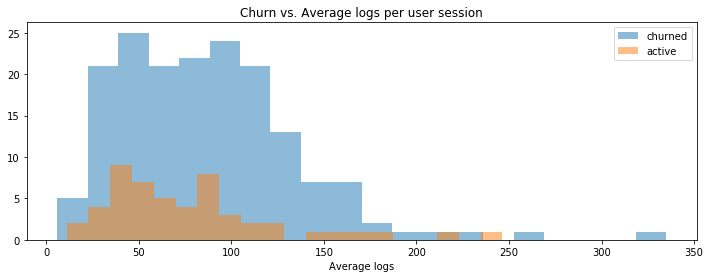

In [1333]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgLogsPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgLogsPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average logs')
ax = plt.gca()
ax.set_title('Churn vs. Average logs per user session');
plt.legend(loc='upper right')
plt.show()

#### Average duration per session 

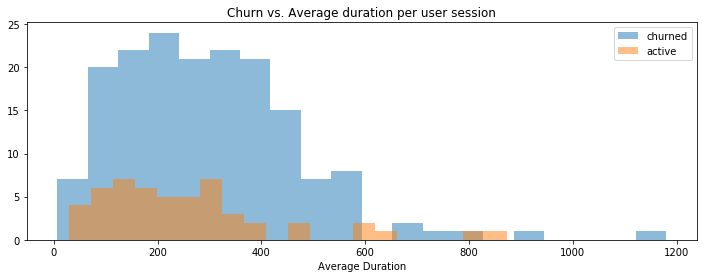

In [1335]:
plt.figure(figsize=(12, 4))
plt.hist(df[df.churn == 0]['avgDurationPerSession'], alpha = 0.5, label="churned", bins = 20)
plt.hist(df[df.churn == 1]['avgDurationPerSession'], alpha = 0.5, label="active", bins = 20)
plt.xlabel('Average Duration')
ax = plt.gca()
ax.set_title('Churn vs. Average duration per user session');
plt.legend(loc='upper right')
plt.show()

### Window Function

In [496]:
from pyspark.sql.functions import row_number

data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))

In [530]:
# GET CHURNED USERS
users = data \
    .where(data.page.isin(['Submit Downgrade', 'Cancellation Confirmation'])) \
    .select('userId') \
    .dropDuplicates() \
    .collect()

# list of userIds
uids = [x.userId for x in users];

# Window
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc())
data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))
    
# final query
data2 \
    .where(data2.rown == 1) \
    .where(data2.userId.isin(uids)) \
    .where((data2.level == 'free') | (data2.page == 'Cancellation Confirmation')) \
    .count()



67

In [ ]:
overUser = window.partitionBy('userId')
w = data.withColumn(
  "rown", array_contains('userId', 'tsDate', 'auth', 'level', 'page', 'status') over overUser).withColumn(
  "total_salary_in_dep", sum('salary) over overCategory)
df.show()

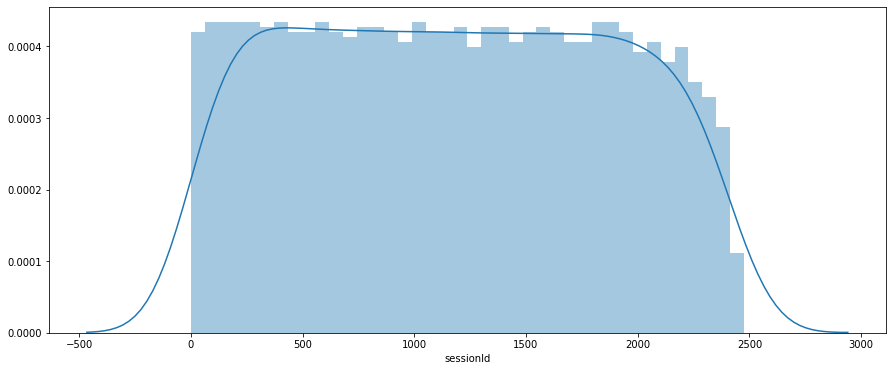

In [1195]:
df = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()
plt.figure(figsize=(15,6))
sb.distplot(df['sessionId'], bins=40)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.